# Dependencies

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import NotFittedError
from sklearn.metrics import r2_score, mean_absolute_error

sns.set()

# Data Preprocess

In [89]:
df = pd.read_csv('mlr_dataset.csv')
df.head(),len(df)

(    SAT  Rand 1,2,3   GPA
 0  1714           1  2.40
 1  1664           3  2.52
 2  1760           3  2.54
 3  1685           3  2.74
 4  1693           2  2.83,
 84)

# Modelling

In [90]:
x = df.drop(['GPA'], axis=1)
y = df['GPA']
x.head(),y.head()

(    SAT  Rand 1,2,3
 0  1714           1
 1  1664           3
 2  1760           3
 3  1685           3
 4  1693           2,
 0    2.40
 1    2.52
 2    2.54
 3    2.74
 4    2.83
 Name: GPA, dtype: float64)

In [91]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, random_state=123)

print (x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(71, 2) (13, 2) (71,) (13,)


In [92]:
pipelines = {
    'ols':make_pipeline(LinearRegression()),
    'rf':make_pipeline(RandomForestRegressor(random_state=1234)),
    'gb':make_pipeline(GradientBoostingRegressor(random_state=1234)),
    'ridge':make_pipeline(Ridge(random_state=1234)),
    'lasso':make_pipeline(Lasso(random_state=1234)),
    'enet':make_pipeline(ElasticNet(random_state=1234)),
}

pipelines

{'ols': Pipeline(steps=[('linearregression', LinearRegression())]),
 'rf': Pipeline(steps=[('randomforestregressor',
                  RandomForestRegressor(random_state=1234))]),
 'gb': Pipeline(steps=[('gradientboostingregressor',
                  GradientBoostingRegressor(random_state=1234))]),
 'ridge': Pipeline(steps=[('ridge', Ridge(random_state=1234))]),
 'lasso': Pipeline(steps=[('lasso', Lasso(random_state=1234))]),
 'enet': Pipeline(steps=[('elasticnet', ElasticNet(random_state=1234))])}

In [93]:
pipelines['ols'].get_params()

{'memory': None,
 'steps': [('linearregression', LinearRegression())],
 'verbose': False,
 'linearregression': LinearRegression(),
 'linearregression__copy_X': True,
 'linearregression__fit_intercept': True,
 'linearregression__n_jobs': None,
 'linearregression__normalize': 'deprecated',
 'linearregression__positive': False}

In [94]:
hypergrid = {
    'ols': {              
    },
    'rf': {
        'randomforestregressor__min_samples_split':[2,4,6],
        'randomforestregressor__min_samples_leaf':[1,2,3]
    },
    'gb':{
        'gradientboostingregressor__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'ridge':{
        'ridge__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'lasso':{
        'lasso__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'enet':{
        'elasticnet__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    }
}

In [95]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hypergrid[algo], cv=10, n_jobs=-1)
    try:
        print('Starting training for {}.'.format(algo))
        model.fit(x_train, y_train)
        fit_models[algo] = model
        print('{} has been successfully fit.'.format(algo))
    except NotFittedError as e:
        print(repr(e))

Starting training for ols.
ols has been successfully fit.
Starting training for rf.
rf has been successfully fit.
Starting training for gb.
gb has been successfully fit.
Starting training for ridge.
ridge has been successfully fit.
Starting training for lasso.
lasso has been successfully fit.
Starting training for enet.
enet has been successfully fit.


In [96]:
fit_models['ridge'].predict(x_test)

array([3.46409181, 3.07673371, 3.07798748, 3.46902579, 3.39830539,
       3.22639781, 3.58657846, 3.49862968, 3.48296485, 3.31607237,
       3.24080887, 3.45954872, 3.32758499])

# Evaluation

In [97]:
df_model_evaluation = pd.DataFrame(columns=['Algo', 'R2 Score', 'Mean Absolute Error'])
index = 0

for algo,model in fit_models.items():
    yhat = model.predict(x_test)
    print('{} scores - R2:{} MAE:{}'.format(algo, r2_score(y_test, yhat), mean_absolute_error(y_test, yhat)))
    
    index += 1
    df_model_evaluation.loc[index] = [algo, r2_score(y_test, yhat), mean_absolute_error(y_test, yhat)]

ols scores - R2:0.3249523992198182 MAE:0.20233238783903187
rf scores - R2:0.2547585015738949 MAE:0.21527279359529342
gb scores - R2:0.3056864775447753 MAE:0.20558319671057643
ridge scores - R2:0.3249650132425227 MAE:0.20233224966436786
lasso scores - R2:0.32291815653921385 MAE:0.20285550042559714
enet scores - R2:0.3241219533965122 MAE:0.202590457625799


In [98]:
df_model_evaluation = df_model_evaluation.sort_values(by='R2 Score', ascending=False).reset_index(drop= True)
df_model_evaluation

,Algo,R2 Score,Mean Absolute Error
0,ridge,0.324965,0.202332
1,ols,0.324952,0.202332
2,enet,0.324122,0.202590
3,lasso,0.322918,0.202856
4,gb,0.305686,0.205583
5,rf,0.254759,0.215273


In [99]:
df_model_evaluation.index

RangeIndex(start=0, stop=6, step=1)

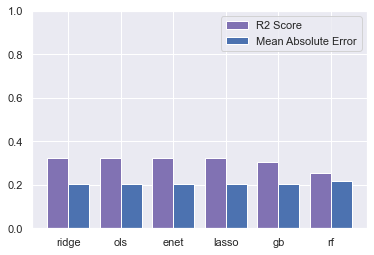

In [100]:
plt.clf()
barwidth = 0.4
x_plot_1 = df_model_evaluation.index
x_plot_2 = x_plot_1+barwidth
y_plot_1 = df_model_evaluation['R2 Score']
y_plot_2 = df_model_evaluation['Mean Absolute Error']
x_ticks = df_model_evaluation['Algo']

plt.bar(x_plot_1, y_plot_1, width=barwidth, color='C254', label= 'R2 Score')
plt.bar(x_plot_2, y_plot_2, width=barwidth, color='C250', label= 'Mean Absolute Error')
plt.xticks(x_plot_1+barwidth/2, x_ticks)
plt.ylim(0,1) 
plt.legend()
plt.show()

In [101]:
best_model = df_model_evaluation.iloc[0,0]
best_model

'ridge'